In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

## Data Modeling Workflow

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1917, 419)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,medication,weeks_comp,cows_predose,cows_postdose
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,6.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,abnormal,abnormal,normal,normal,abnormal,2.0,27,8.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,abnormal,1.0,27,8.0,5.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,9.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,not_present,not_present,not_present,not_present,not_present,not_present,2.0,1,0.0,0.0


## Review Tests

In [3]:
# choose the drug tests you want to include in the model
# comment out the drugs you don't want to include
drug_names = [
 #'Propoxyphene',
 #'Amphetamines',
 'Cannabinoids',
 #'Benzodiazepines',
 #'MMethadone',
 #'Oxycodone',
 'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# Function to check if the suffix of the column name is numerically <= 4
# The suffix represents the week of treatment
# we only want columns that include data from the first 4 weeks of treatment
def search_suffix(col_name):
	match = re.search(r'(\d+)$', col_name)  # Look for one or more digits at the end of the string
	if match:
		return int(match.group(1)) <= 4  # Convert the found digits to an integer and check if <= 4
	return False

# List comprehension to extract matching columns
matching_columns = [
	col for col in data.columns 
	if any(col.startswith('test_'+drug) and search_suffix(col) for drug in drug_names)
]

# Use the matching_columns list to select the columns from the DataFrame
tests = data[matching_columns]

print('Shape of tests DataFrame:', tests.shape)
display(tests)

Shape of tests DataFrame: (1917, 15)


,test_Cannabinoids_0,test_Cocaine_0,test_Opiate300_0,test_Cannabinoids_1,test_Cocaine_1,test_Opiate300_1,test_Cannabinoids_2,test_Cocaine_2,test_Opiate300_2,test_Cannabinoids_3,test_Cocaine_3,test_Opiate300_3,test_Cannabinoids_4,test_Cocaine_4,test_Opiate300_4
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1914,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1915,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [4]:
# comment out the drugs you don't want to include
survey_names = [
'cannabis',
'cocaine',
'alcohol',
#'oxycodone',
#'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# Function to check if the suffix of the column name is numerically <= 4
# we only want columns that include data from the first 4 weeks of treatment
def has_suffix_leq_4(col_name):
	match = re.search(r'(\d+)$', col_name)  # Look for one or more digits at the end of the string
	if match:
		return int(match.group(1)) <= 4  # Convert the found digits to an integer and check if <= 4
	return False

# List comprehension to extract matching columns
matching_columns = [
	col for col in data.columns 
	if any(col.startswith('survey_'+survey) and has_suffix_leq_4(col) for survey in survey_names)
]

# Use the matching_columns list to select the columns from the DataFrame
survey = data[matching_columns]

print('Shape of tests DataFrame:', tests.shape)
display(survey)


Shape of tests DataFrame: (1917, 15)


,survey_cannabis_0,survey_cocaine_0,survey_alcohol_0,survey_opiates_0,survey_cannabis_4,survey_cocaine_4,survey_alcohol_4,survey_opiates_4
0,0.0,0.0,0.0,30.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,30.0,1.0,0.0,0.0,5.0
2,0.0,23.0,0.0,30.0,0.0,9.0,18.0,9.0
3,1.0,2.0,0.0,30.0,2.0,1.0,1.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
1913,0.0,0.0,1.0,30.0,0.0,0.0,0.0,3.0
1914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [5]:
# attendance data, included up to week 4
rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# medication data, included up to week 4
meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

# cow data, included for baseline and week 0
cows = data[[col for col in data.columns if 'cows' in col]]

# create dataframe with numeric features
num_df = pd.concat([tests, survey, rsa, meds, cows], axis=1)

print('Shape of numeric dataframe',num_df.shape)
display(num_df)

Shape of numeric dataframe (1917, 40)


,test_Cannabinoids_0,test_Cocaine_0,test_Opiate300_0,test_Cannabinoids_1,test_Cocaine_1,test_Opiate300_1,test_Cannabinoids_2,test_Cocaine_2,test_Opiate300_2,test_Cannabinoids_3,...,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,11.0,6.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,8.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,8.0,5.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,11.0,9.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,270.0,0.0,250.0,0.0,300.0,0.0,360.0,0.0,0.0,0.0
1913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,17.0,12.0
1914,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,0.0,0.0
1915,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,0.0,0.0


## Review Categorical

In [6]:
# demographic data
dem = data[[col for col in data.columns if col.startswith('dem_')]]
dem = pd.get_dummies(dem, dtype=int)
# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]
dsm = pd.get_dummies(dsm, dtype=int)
# create df for medical history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]
mdh = pd.get_dummies(mdh, dtype=int)

# create df for physical exam
pex = data[[col for col in data.columns if col.startswith('pex_')]]
pex = pd.get_dummies(pex, dtype=int)

# concat cat features into cat_df

# one hot encode cat_df
cat_df = pd.concat([dsm, dem, mdh, pex], axis=1)

print(cat_df.shape)
display(cat_df)



(1917, 145)


,dsm_cannabis_abuse,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_evaluated,dsm_cannabis_not_present,dsm_cocaine_abuse,dsm_cocaine_dependence,dsm_cocaine_no_diagnosis,dsm_cocaine_not_evaluated,dsm_cocaine_not_present,...,pex_head_neck_not_evaluated,pex_head_neck_not_present,pex_cardio_abnormal,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_abnormal,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1913,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1914,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1915,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


## Assign Target Variable and Combine

In [7]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1917, 186)


,test_Cannabinoids_0,test_Cocaine_0,test_Opiate300_0,test_Cannabinoids_1,test_Cocaine_1,test_Opiate300_1,test_Cannabinoids_2,test_Cocaine_2,test_Opiate300_2,test_Cannabinoids_3,...,pex_head_neck_not_present,pex_cardio_abnormal,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_abnormal,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present,dropout
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,1,0,0,0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0,0,1,0,0,1,0,0,0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0,0,1,0,0,0,1,0,0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,1,0,0,1,0,0,0,0.0
1913,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,1.0
1914,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,1,0,0,0,0,1,0,0,0.0
1915,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,1,0,0,0,1,0.0


## Save to CSV for ML Pipelines

In [8]:
# save to csv
new_data.to_csv('../data/classification_df.csv', index=False)

## Classification Workflow

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1341, 185)
Shape of X_val: (192, 185)
Shape of X_test: (384, 185)


In [10]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
	'subsample': [0.3, 0.5, 0.9],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=4, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'objective': 'binary:logistic', 'subsample': 0.5}
Highest ROC AUC found:  0.896304561575255


In [11]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

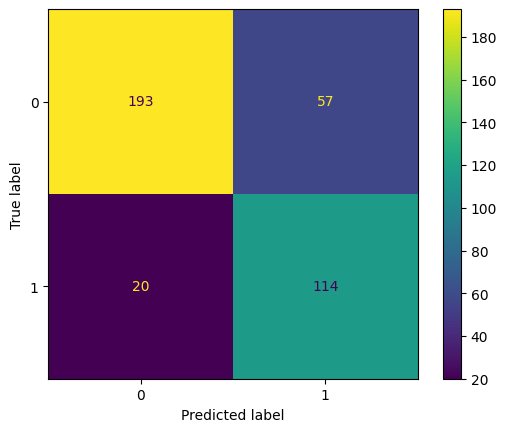

In [12]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

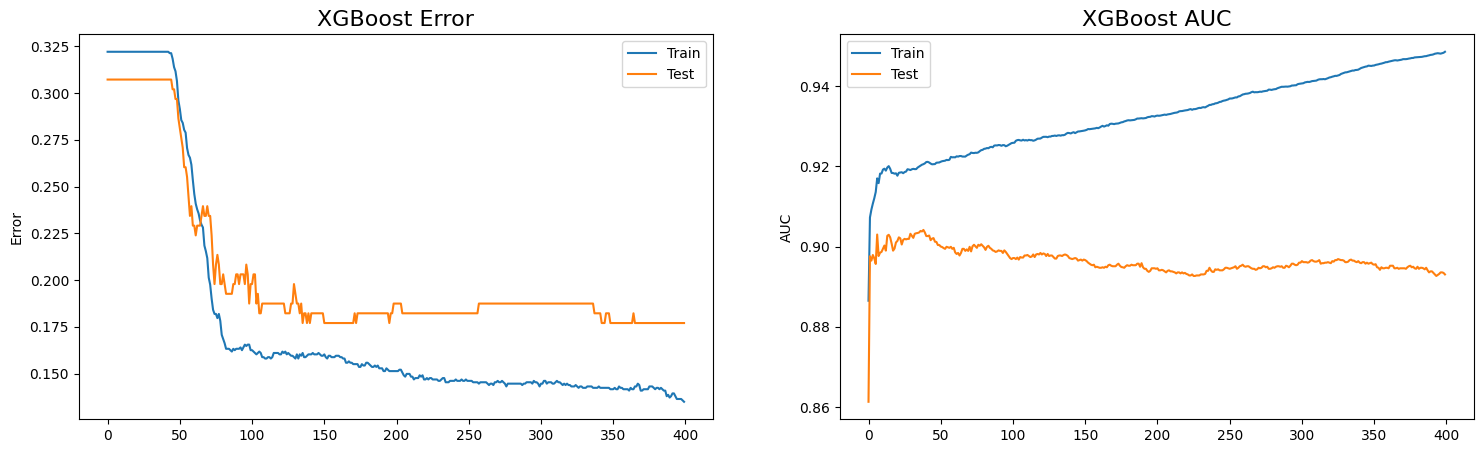

In [13]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [14]:
# Print the classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

# print accuracy for train, val and test
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))


Train Accuracy:  0.8650260999254288
Validation Accuracy:  0.8229166666666666
Test Accuracy:  0.7994791666666666


In [15]:
# print classification report for training
print('Train Classification Report')
print(classification_report(y_train, y_pred_train))

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       909
         1.0       0.73      0.91      0.81       432

    accuracy                           0.87      1341
   macro avg       0.84      0.88      0.85      1341
weighted avg       0.88      0.87      0.87      1341



In [16]:
# Print the classification report for test
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

Test classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83       250
         1.0       0.67      0.85      0.75       134

    accuracy                           0.80       384
   macro avg       0.79      0.81      0.79       384
weighted avg       0.82      0.80      0.80       384



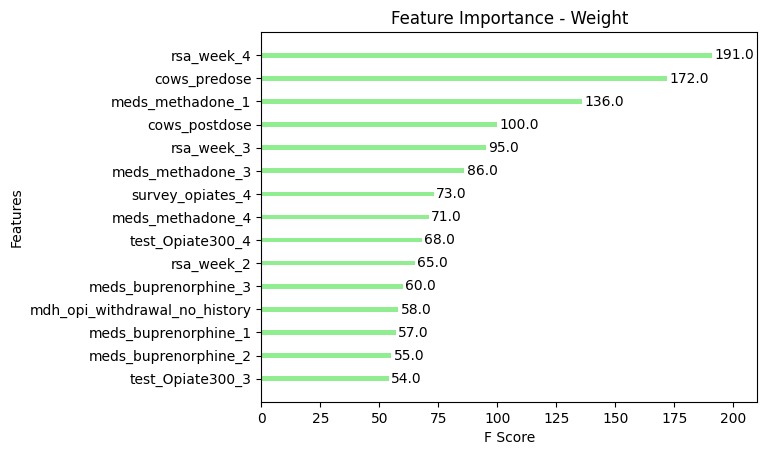

In [17]:
# plot feature importance
xgb.plot_importance(grid_auc.best_estimator_, importance_type='weight', max_num_features=15, title='Feature Importance - Weight', xlabel='F Score', ylabel='Features', color='lightgreen', grid=False)
plt.show()

In [18]:
# Assuming `model` is your trained model and `X_test`, `y_test` are your test datasets
predictions = best_gbm.predict(X_test)

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add predictions and actual labels to the DataFrame
X_test_df['Prediction'] = predictions
X_test_df['Actual'] = y_test

# Function to classify each prediction
def classify_prediction(row):
	if row['Prediction'] == row['Actual']:
		return 'TP' if row['Prediction'] == 1 else 'TN'
	else:
		return 'FP' if row['Prediction'] == 1 else 'FN'

# Apply the function to classify predictions
X_test_df['Classification'] = X_test_df.apply(classify_prediction, axis=1)

# Now X_test_df includes the test data, predictions, actual labels, and classification (TP, TN, FP, FN)
X_test_df

,test_Cannabinoids_0,test_Cocaine_0,test_Opiate300_0,test_Cannabinoids_1,test_Cocaine_1,test_Opiate300_1,test_Cannabinoids_2,test_Cocaine_2,test_Opiate300_2,test_Cannabinoids_3,...,pex_cardio_normal,pex_cardio_not_evaluated,pex_cardio_not_present,pex_skin_abnormal,pex_skin_normal,pex_skin_not_evaluated,pex_skin_not_present,Prediction,Actual,Classification
477,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1,0,0,1,0,0,0,1,1.0,TP
542,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,0,0,1,0,0,0,1,1.0,TP
221,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,1,0,0,0,1,0,0.0,TN
1799,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,1,0,0,0,0,1.0,FN
725,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,0,0,1,0,0,0,0,0.0,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1,0,0,0,1,0,0,1,1.0,TP
513,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,1,0,0,0,1,0,0.0,TN
1689,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,1,1.0,TP
841,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0,1,0,0,1,0.0,FP


## Create a DF with all the trees

In [19]:
# Assuming `grid_auc` is your trained GridSearchCV object with an XGBClassifier
best_model = grid_auc.best_estimator_

# Extract the Booster
booster = best_model.get_booster()

# Convert the trees to a DataFrame
trees_df = booster.trees_to_dataframe()

trees_df.loc[trees_df['Feature']=='rsa_week_4']

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,rsa_week_4,1.0,0-1,0-2,0-2,258.446320,143.115494,NaN
13,1,0,1-0,rsa_week_4,1.0,1-1,1-2,1-2,272.322662,148.151581,NaN
26,2,0,2-0,rsa_week_4,1.0,2-1,2-2,2-2,250.558167,146.279617,NaN
41,3,0,3-0,rsa_week_4,1.0,3-1,3-2,3-2,238.116364,148.705475,NaN
56,4,0,4-0,rsa_week_4,1.0,4-1,4-2,4-2,262.579041,145.748901,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4124,314,0,314-0,rsa_week_4,1.0,314-1,314-2,314-2,7.501467,87.209801,NaN
4355,333,0,333-0,rsa_week_4,1.0,333-1,333-2,333-2,6.706043,82.049522,NaN
4496,344,0,344-0,rsa_week_4,1.0,344-1,344-2,344-2,4.900710,84.512489,NaN
4806,368,0,368-0,rsa_week_4,1.0,368-1,368-2,368-2,6.017882,83.116844,NaN


## Plot the Estimator with the Desired Feature

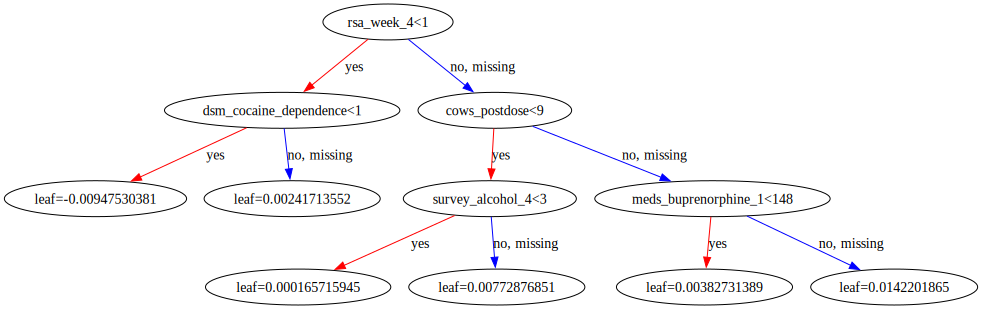

In [22]:
graph = xgb.to_graphviz(booster, num_trees=314)
graph

In [21]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load a dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual pipelines for each classifier
clf1 = make_pipeline(StandardScaler(), LogisticRegression(random_state=1))
clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))
clf3 = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# Combine them in a VotingClassifier
eclf = VotingClassifier(estimators=[
		('lr', clf1), ('rf', clf2), ('gbc', clf3)],
		voting='hard')

# Fit the ensemble classifier
eclf.fit(X_train, y_train)

# Now you can use eclf to predict and evaluate
print(eclf.score(X_test, y_test))

1.0
